In [15]:
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
import numpy as np 
from keras.preprocessing.text import Tokenizer
from matplotlib import pyplot as plt



# 1.load sentences and wiki-vector and then count 

### load datasets-sentences from quora

In [2]:
train = pd.read_csv("quora-insincere-questions-classification/train.csv")
test = pd.read_csv("quora-insincere-questions-classification/test.csv")
print("Train shape : ",train.shape)
print("Test shape : ",test.shape)

Train shape :  (1306122, 3)
Test shape :  (375806, 2)


In [20]:
train[:2]

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0


In [5]:
print('Average word length of questions in train is {0:.0f}.'.format(np.mean(train['question_text'].apply(lambda x: len(x.split())))))
print('Average word length of questions in test is {0:.0f}.'.format(np.mean(test['question_text'].apply(lambda x: len(x.split())))))

Average word length of questions in train is 13.
Average word length of questions in test is 13.


In [6]:
print('Max word length of questions in train is {0:.0f}.'.format(np.max(train['question_text'].apply(lambda x: len(x.split())))))
print('Max word length of questions in test is {0:.0f}.'.format(np.max(test['question_text'].apply(lambda x: len(x.split())))))

Max word length of questions in train is 134.
Max word length of questions in test is 87.


In [7]:
print('Average character length of questions in train is {0:.0f}.'.format(np.mean(train['question_text'].apply(lambda x: len(x)))))
print('Average character length of questions in test is {0:.0f}.'.format(np.mean(test['question_text'].apply(lambda x: len(x)))))

Average character length of questions in train is 71.
Average character length of questions in test is 71.


In [12]:
max_features = 120000
tk = Tokenizer(lower = True, filters='', num_words=max_features)
full_text = list(train['question_text'].values) + list(test['question_text'].values)
tk.fit_on_texts(full_text)

In [13]:
train_tokenized = tk.texts_to_sequences(train['question_text'].fillna('missing'))
test_tokenized = tk.texts_to_sequences(test['question_text'].fillna('missing'))

Text(0.5, 1.0, 'Distribution of question text length in characters')

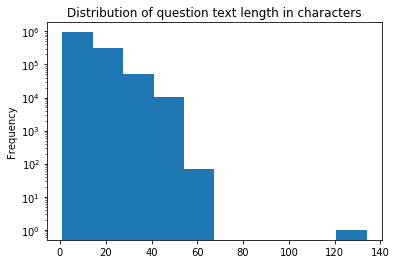

In [16]:
train['question_text'].apply(lambda x: len(x.split())).plot(kind='hist')
plt.yscale('log')
plt.title('Distribution of question text length in characters')

In [ ]:
max_len = 72
maxlen = 72

### count the number of words

In [10]:
def build_vocab(sentences, verbose =  True):
    """
    :param sentences: list of list of words
    :return: dictionary of words and their count
    """
    vocab = {}
    for sentence in tqdm(sentences, disable = (not verbose)):
        for word in sentence:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab

In [11]:
sentences = train["question_text"].progress_apply(lambda x: x.split()).values
vocab = build_vocab(sentences) # vocab: frequency dictionary about quora text
print({k: vocab[k] for k in list(vocab)[:5]})

100%|██████████| 1306122/1306122 [00:03<00:00, 357295.72it/s]


{'How': 261930, 'did': 33489, 'Quebec': 97, 'nationalists': 91, 'see': 9003}


### load word vectors:wiki-news-300d-1M.vec 

In [12]:

from gensim.models import KeyedVectors
if 'embeddings_index' not in globals():
    embeddings_index = KeyedVectors.load_word2vec_format("quora-insincere-questions-classification/embeddings/wiki-news-300d-1M/wiki-news-300d-1M.vec",binary=False)
else:
    print('embeddings_index already exists')
# word_vectors

# 2. Data Preprocessing

## deal with words

### 1) replace mispelling words or  abbreviation

In [13]:
mispell_dict = {'colour': 'color', 'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling', 'counselling': 'counseling', 'theatre': 'theater',
                'cancelled': 'canceled', 'labour': 'labor', 'organisation': 'organization', 'wwii': 'world war 2', 'citicise': 'criticize', 'youtu ': 'youtube ', 
                'Qoura': 'Quora', 'sallary': 'salary', 'Whta': 'What', 'narcisist': 'narcissist', 'howdo': 'how do', 'whatare': 'what are', 'howcan': 'how can', 
                'howmuch': 'how much', 'howmany': 'how many', 'whydo': 'why do', 'doI': 'do I', 'theBest': 'the best', 'howdoes': 'how does', 
                'mastrubation': 'masturbation', 'mastrubate': 'masturbate', "mastrubating": 'masturbating', 'pennis': 'penis', 'Etherium': 'Ethereum', 
                'narcissit': 'narcissist', 'bigdata': 'big data', '2k17': '2017', '2k18': '2018', 'qouta': 'quota', 'exboyfriend': 'ex boyfriend',
                'airhostess': 'air hostess', "whst": 'what', 'watsapp': 'whatsapp', 'demonitisation': 'demonetization', 'demonitization': 'demonetization',
                'demonetisation': 'demonetization',"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", 
                "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", 
                "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will",
                "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", 
                "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", 
                "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", 
                "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not",
                "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", 
                "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", 
                "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", 
                "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would",
                "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", 
                "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", 
                "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have",
                "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", 
                "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", 
                "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will",
                "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", 
                "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have",
                "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have",
                'MeToo':'me too'}

In [14]:
def correct_spelling(x, dic):
    for word in dic.keys():
        x = x.replace(word, dic[word])
    return x

In [15]:
train["question_text"] =  train["question_text"].progress_apply(lambda x: correct_spelling(x, mispell_dict))
sentences = train["question_text"].apply(lambda x: x.split())
vocab = build_vocab(sentences)

100%|██████████| 1306122/1306122 [00:03<00:00, 342647.45it/s]


### 2) delete all punctuations

In [16]:
for punct in '?!.,"#$%\'()*+-/:;<=>@[\\]^_`{|}~' + '“”’':
    if punct in embeddings_index:
        print(punct)
    else:
        print('\t\t\t\t',punct)

?
!
.
,
"
#
$
%
'
(
)
*
+
-
/
:
;
<
=
>
@
[
\
]
^
				 _
				 `
{
|
}
~
“
”
’


In [17]:
# transfer this to kaggle code
def clean_text(x):
    x = str(x)
    for punct in '?!.,"#$%\'()*+-/:;<=>@[\\]^{|}~' + '“”’':
        x = x.replace(punct, ' ')
    for punct in '_`':
        x = x.replace(punct, ' ')
    return x

In [18]:
# transfer this to kaggle code
train["question_text"] = train["question_text"].progress_apply(lambda x: clean_text(x))
# leave codes below, don't transfer these
sentences = train["question_text"].apply(lambda x: x.split())
vocab = build_vocab(sentences)

100%|██████████| 1306122/1306122 [00:03<00:00, 382303.74it/s]


In [33]:
oov = check_coverage(vocab,embeddings_index)

100%|██████████| 241303/241303 [00:00<00:00, 282460.52it/s]


Found embeddings for 66.55% of vocab
Found embeddings for  99.24% of all text


## calculate the ratio of word or total quantities 



In [32]:
#the number of : word in wiki/word in quora
#the total quantities of : word in wiki/word in quora
import operator 

def check_coverage(vocab,embeddings_index):
    a = {}
    oov = {}
    k = 0
    i = 0
    for word in tqdm(vocab):
        try:
            a[word] = embeddings_index[word]
            k += vocab[word]
        except:

            oov[word] = vocab[word]
            i += vocab[word]
            pass

    print('Found embeddings for {:.2%} of vocab'.format(len(a) / len(vocab)))
    print('Found embeddings for  {:.2%} of all text'.format(k / (k + i)))
    sorted_x = sorted(oov.items(), key=operator.itemgetter(1))[::-1]

    return sorted_x

## 3. deal with words that are not included in wiki
 ### a. count the ratio of words that are not included in wiki : g/(g+b)
 g means the amounts of the word that appears in good_sentences.
 b means the amounts of the word that appears in bad_sentences.
 ### b. separate good and bad sentences
 Put sentences with train['label']==1 and train['label']==0 separately in dict good_sentences and dict bad_sentences.
 Each key is the index in train['queation_text'].
 Each value is the sentence in the type of list .
### c. count the ratio of selected words from datasets
select 1000 sentences randomly from good_sentences.values() and bad_sentences.values() and then calculate the ratio: g/(g+b)
### d. replace words in wiki with selected words


### a. count the ratio of words that are not included in wiki 

In [20]:
import json
import numpy as np
class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(NpEncoder, self).default(obj)

In [21]:
import json
with open('miss_embedding_dict.txt','r') as json_file:
    data = json.load(json_file)
    print(data)
json_file.close()   

{'Quorans': [[1129, 1, 1], [5478, 0, 1], [12771, 1, 1], [12843, 0, 1], [12946, 0, 1], [14685, 0, 1], [15402, 0, 1], [22208, 0, 1], [23220, 0, 1], [23259, 0, 1], [23687, 0, 1], [23757, 0, 1], [25098, 0, 1], [26709, 0, 1], [28225, 1, 1], [38984, 0, 1], [45119, 0, 1], [46257, 1, 1], [48998, 0, 1], [49385, 0, 1], [50851, 0, 1], [51918, 0, 1], [52728, 0, 1], [56068, 0, 1], [57451, 1, 1], [58087, 1, 1], [58731, 0, 1], [58737, 0, 1], [59525, 1, 1], [63112, 0, 1], [67541, 0, 1], [69276, 0, 1], [72968, 0, 1], [75308, 1, 1], [77348, 0, 1], [78931, 1, 1], [79683, 0, 1], [80052, 0, 1], [80839, 0, 1], [80954, 1, 1], [81104, 0, 1], [81602, 0, 1], [84459, 1, 1], [86495, 0, 1], [87078, 0, 1], [87098, 0, 1], [87824, 0, 1], [88586, 0, 1], [88981, 0, 1], [93547, 0, 1], [93576, 0, 1], [94971, 1, 1], [97479, 0, 1], [97987, 0, 1], [98042, 0, 1], [99756, 0, 1], [100764, 0, 1], [100889, 0, 1], [102132, 0, 1], [102243, 0, 1], [103607, 0, 1], [103859, 1, 1], [103979, 0, 1], [104825, 0, 1], [105994, 1, 1], [1069

In [22]:
def count_times(x):
    cnt = 0
    for i in x:
        if i[1] == 1:
            cnt += 1
    return cnt

In [23]:
c = 0
for i in data:
    bad_times = count_times(data[i])
    print(i)
    print('good_sentences: ',len(data[i]) - bad_times,'\tbad_sentences: ',bad_times, '\tbad/(good+bad): ',bad_times/len(data[i]))
    
    # comment these two lines to see the whole info
    c += 1
    if c == 5:
        break

Quorans
good_sentences:  629 	bad_sentences:  205 	bad/(good+bad):  0.24580335731414868
BITSAT
good_sentences:  545 	bad_sentences:  0 	bad/(good+bad):  0.0
COMEDK
good_sentences:  347 	bad_sentences:  1 	bad/(good+bad):  0.0028735632183908046
KVPY
good_sentences:  343 	bad_sentences:  0 	bad/(good+bad):  0.0
Quoran
good_sentences:  238 	bad_sentences:  66 	bad/(good+bad):  0.21710526315789475


In [24]:
len1 = 0
thre = 0.01
verygood_word_replace = {}
for i in data:
    bad_times = count_times(data[i])
    if bad_times/len(data[i])<thre:
        verygood_word_replace[i]='fresher'
        print(i)
        print('good_sentences: ',len(data[i]) - bad_times,'\tbad_sentences: ',bad_times, '\tbad/(good+bad): ',bad_times/len(data[i]))
        len1 += 1
print("\nnumbers of words which bad/total exceed threshold:",thre,'is:',len1)

BITSAT
good_sentences:  545 	bad_sentences:  0 	bad/(good+bad):  0.0
COMEDK
good_sentences:  347 	bad_sentences:  1 	bad/(good+bad):  0.0028735632183908046
KVPY
good_sentences:  343 	bad_sentences:  0 	bad/(good+bad):  0.0
WBJEE
good_sentences:  229 	bad_sentences:  0 	bad/(good+bad):  0.0
mtech
good_sentences:  216 	bad_sentences:  0 	bad/(good+bad):  0.0
articleship
good_sentences:  185 	bad_sentences:  0 	bad/(good+bad):  0.0
VITEEE
good_sentences:  181 	bad_sentences:  1 	bad/(good+bad):  0.005494505494505495
aadhar
good_sentences:  145 	bad_sentences:  1 	bad/(good+bad):  0.00684931506849315
marksheet
good_sentences:  130 	bad_sentences:  0 	bad/(good+bad):  0.0
UCEED
good_sentences:  121 	bad_sentences:  0 	bad/(good+bad):  0.0
AFCAT
good_sentences:  121 	bad_sentences:  0 	bad/(good+bad):  0.0
bcom
good_sentences:  118 	bad_sentences:  0 	bad/(good+bad):  0.0
dropshipping
good_sentences:  107 	bad_sentences:  1 	bad/(good+bad):  0.009259259259259259
UPSEE
good_sentences:  100 	b

good_sentences:  9 	bad_sentences:  0 	bad/(good+bad):  0.0
AEEE
good_sentences:  9 	bad_sentences:  0 	bad/(good+bad):  0.0
JECRC
good_sentences:  8 	bad_sentences:  0 	bad/(good+bad):  0.0
persentage
good_sentences:  9 	bad_sentences:  0 	bad/(good+bad):  0.0
PGCIL
good_sentences:  9 	bad_sentences:  0 	bad/(good+bad):  0.0
USDT
good_sentences:  9 	bad_sentences:  0 	bad/(good+bad):  0.0
IERT
good_sentences:  9 	bad_sentences:  0 	bad/(good+bad):  0.0
Isit
good_sentences:  9 	bad_sentences:  0 	bad/(good+bad):  0.0
apj
good_sentences:  9 	bad_sentences:  0 	bad/(good+bad):  0.0
TNEA
good_sentences:  9 	bad_sentences:  0 	bad/(good+bad):  0.0
ARKit
good_sentences:  9 	bad_sentences:  0 	bad/(good+bad):  0.0
doea
good_sentences:  9 	bad_sentences:  0 	bad/(good+bad):  0.0
fz25
good_sentences:  8 	bad_sentences:  0 	bad/(good+bad):  0.0
badoo
good_sentences:  9 	bad_sentences:  0 	bad/(good+bad):  0.0
GPAT
good_sentences:  9 	bad_sentences:  0 	bad/(good+bad):  0.0
ebiz
good_sentences: 

In [25]:
len1 = 0
thre = 0.5
bad_word_replace={}
for i in data:
    bad_times = count_times(data[i])
    if bad_times/len(data[i])>thre:
        print(i)
        print('good_sentences: ',len(data[i]) - bad_times,'\tbad_sentences: ',bad_times, '\tbad/(good+bad): ',bad_times/len(data[i]))
        len1 += 1
print("\nnumbers of words which bad/total exceed threshold:",thre,'is:',len1)

bhakts
good_sentences:  11 	bad_sentences:  52 	bad/(good+bad):  0.8253968253968254
Bhakts
good_sentences:  11 	bad_sentences:  38 	bad/(good+bad):  0.7755102040816326
Skripal
good_sentences:  18 	bad_sentences:  22 	bad/(good+bad):  0.55
rohingya
good_sentences:  8 	bad_sentences:  12 	bad/(good+bad):  0.6
Trumpers
good_sentences:  6 	bad_sentences:  14 	bad/(good+bad):  0.7
Strzok
good_sentences:  6 	bad_sentences:  11 	bad/(good+bad):  0.6470588235294118
bhakt
good_sentences:  2 	bad_sentences:  14 	bad/(good+bad):  0.875
Brexiters
good_sentences:  6 	bad_sentences:  7 	bad/(good+bad):  0.5384615384615384
wumao
good_sentences:  3 	bad_sentences:  9 	bad/(good+bad):  0.75
Tamilans
good_sentences:  3 	bad_sentences:  8 	bad/(good+bad):  0.7272727272727273
Feku
good_sentences:  4 	bad_sentences:  7 	bad/(good+bad):  0.6363636363636364
nibiru
good_sentences:  2 	bad_sentences:  6 	bad/(good+bad):  0.75
Sanghis
good_sentences:  1 	bad_sentences:  8 	bad/(good+bad):  0.8888888888888888
ro

### b. separate good and bad sentences

In [26]:
good_sentence = {}
bad_sentence = {}
for e_index in range(len(train['question_text'])):
    if train['target'][e_index]==0: 
        good_sentence[e_index]=[train['question_text'][e_index]]
    elif train['target'][e_index]==1:
        bad_sentence[e_index]=[train['question_text'][e_index]]
with open('good_sentence.txt','w') as file:
    json.dump(good_sentence,file,cls=NpEncoder)
file.close()
with open('bad_sentence.txt','w') as file:
    json.dump(bad_sentence,file,cls=NpEncoder)
file.close()

In [27]:
import random
index = random.sample(list(good_sentence.keys()),1000)
good_words=[]
word = {}
for i in index:
    for good_word in train['question_text'][i].split():
        if good_word not in good_words: 
            good_words.append(good_word)
print(index)
print(good_words)


[1094782, 1232196, 589019, 744733, 1137765, 366637, 116660, 111277, 486051, 204861, 1001925, 449580, 621137, 593986, 148033, 198783, 1171843, 1048807, 653727, 854463, 971713, 1164048, 782654, 331116, 361946, 312008, 1083833, 219836, 25831, 1116693, 677473, 643807, 1009932, 118978, 1013007, 1130947, 567771, 1051946, 419378, 962538, 881457, 496180, 44243, 318828, 502191, 200551, 901977, 293252, 728475, 110155, 210412, 197705, 798156, 92083, 1029043, 1101786, 1154609, 861014, 678606, 100201, 1237690, 294650, 88974, 921702, 507488, 1092408, 1035260, 88533, 666446, 305603, 298980, 600572, 604013, 132493, 794252, 130962, 84510, 44752, 264320, 752624, 613340, 1122576, 1092687, 29032, 202609, 744918, 585647, 888239, 824164, 133264, 79906, 83239, 186749, 984227, 802643, 138074, 852853, 202895, 635806, 244640, 539072, 221541, 23493, 77572, 1086574, 1045091, 605968, 934620, 1064829, 974739, 133763, 479216, 538478, 482789, 893904, 716033, 182491, 459359, 373762, 343934, 525298, 468796, 80792, 1232

### c. count the ratio of selected words from datasets(Don't run it again(cost more time))

In [45]:
for each in good_words:
    good_num = 0
    bad_num = 0
    for i in good_sentence.values():
        good_num+=i[0].count(each)
    for i in bad_sentence.values():
        bad_num+=i[0].count(each)
    if bad_num/(good_num+bad_num)<=0.001:
        print(each, "\t",good_num,"\t", bad_num,"\t", bad_num/(good_num+bad_num))



cocci 	 7 	 0 	 0.0
Sputum 	 1 	 0 	 0.0
farro 	 1 	 0 	 0.0
ECE 	 1188 	 1 	 0.0008410428931875525
subah 	 2 	 0 	 0.0
sapphire 	 21 	 0 	 0.0
gemstone 	 50 	 0 	 0.0
Marquesa 	 4 	 0 	 0.0
Montemayor 	 1 	 0 	 0.0
JAGs 	 2 	 0 	 0.0
ohms 	 41 	 0 	 0.0
Pathways 	 4 	 0 	 0.0
cashew 	 30 	 0 	 0.0
Maxbounty 	 1 	 0 	 0.0
Account 	 164 	 0 	 0.0
DTE 	 17 	 0 	 0.0
CAP 	 106 	 0 	 0.0
JBIMS 	 32 	 0 	 0.0
iCici 	 1 	 0 	 0.0
ifsc 	 9 	 0 	 0.0
Ravenswood 	 4 	 0 	 0.0
prelims 	 286 	 0 	 0.0
gratifying 	 7 	 0 	 0.0
Meander 	 2 	 0 	 0.0
Wander 	 11 	 0 	 0.0
microperforate 	 2 	 0 	 0.0
curmudgeons 	 1 	 0 	 0.0
groundhog 	 9 	 0 	 0.0
counterparties 	 1 	 0 	 0.0
FICC 	 1 	 0 	 0.0
batsmen 	 39 	 0 	 0.0
ibogaine 	 1 	 0 	 0.0
fibrous 	 14 	 0 	 0.0
bouquet 	 12 	 0 	 0.0
voce 	 8 	 0 	 0.0
Genu 	 15 	 0 	 0.0
varum 	 3 	 0 	 0.0
piano 	 540 	 0 	 0.0
mouthwash 	 29 	 0 	 0.0
chassis 	 32 	 0 	 0.0
summary 	 442 	 0 	 0.0
Collaboration 	 9 	 0 	 0.0
Kills 	 2 	 0 	 0.0
Creativity 	 7 

benzodiazepines 	 13 	 0 	 0.0
docs 	 75 	 0 	 0.0
Stratego 	 2 	 0 	 0.0
logad 	 1 	 0 	 0.0
lagod 	 1 	 0 	 0.0
reformations 	 1 	 0 	 0.0
methodologies 	 25 	 0 	 0.0
Stephenie 	 26 	 0 	 0.0
infomation 	 5 	 0 	 0.0
Chekhov 	 12 	 0 	 0.0
Diplomo 	 1 	 0 	 0.0
pinhole 	 29 	 0 	 0.0
Bradford 	 15 	 0 	 0.0
Cannon 	 24 	 0 	 0.0
domicile 	 156 	 0 	 0.0
constructions 	 24 	 0 	 0.0
trisections 	 1 	 0 	 0.0
6200 	 16 	 0 	 0.0
63ft 	 1 	 0 	 0.0
Claiming 	 2 	 0 	 0.0
counytry 	 1 	 0 	 0.0
taxable 	 88 	 0 	 0.0
Alvar 	 20 	 0 	 0.0
Nuneza 	 1 	 0 	 0.0
sriram 	 5 	 0 	 0.0
Fourier 	 47 	 0 	 0.0
Azure 	 120 	 0 	 0.0
ETF 	 131 	 0 	 0.0
SP500 	 1 	 0 	 0.0
rrsult 	 1 	 0 	 0.0
workshop 	 123 	 0 	 0.0
NARDL 	 1 	 0 	 0.0
Stata 	 6 	 0 	 0.0
Eviews 	 2 	 0 	 0.0
armor 	 290 	 0 	 0.0
evocative 	 6 	 0 	 0.0
SSBE 	 1 	 0 	 0.0
Vegeta 	 131 	 0 	 0.0
384 	 20 	 0 	 0.0
Ketchup 	 2 	 0 	 0.0
ANSI 	 9 	 0 	 0.0
Guide 	 77 	 0 	 0.0
asbergers 	 1 	 0 	 0.0
lobbist 	 1 	 0 	 0.0
i3 	 105

In [46]:
import random
index = random.sample(list(bad_sentence.keys()),1000)
bad_words=[]
word = {}
for i in index:
    for bad_word in train['question_text'][i].split():
        if bad_word not in bad_words: 
            bad_words.append(bad_word)
print(index)
print(bad_words)



[1248643, 640657, 1120400, 641017, 300790, 583405, 222410, 1212486, 501890, 982256, 295110, 829811, 484433, 188765, 49341, 78505, 1270567, 822739, 363458, 22392, 1253320, 825163, 1243279, 635438, 349925, 1056151, 879295, 903723, 380126, 118182, 973865, 184431, 640101, 548835, 361440, 429919, 1160425, 377982, 206410, 498969, 500863, 720267, 1068536, 204263, 1078692, 471760, 541979, 337409, 1270979, 650332, 666845, 53453, 215590, 1181991, 838709, 207170, 208588, 853915, 543159, 339504, 929157, 268884, 652087, 331833, 557324, 1041924, 1158898, 526368, 522640, 299107, 706170, 627447, 210522, 1054492, 824791, 98653, 797323, 1272428, 1271206, 381239, 381482, 710461, 756668, 525899, 477429, 1104532, 993994, 353310, 1283374, 236700, 304754, 1063446, 1254172, 896088, 1129198, 654796, 434657, 920083, 554724, 325525, 276188, 650863, 514288, 997251, 1226854, 714632, 1218036, 923633, 710849, 279583, 283436, 983504, 482960, 77535, 821633, 485754, 357962, 468681, 615732, 1256575, 792120, 197714, 1155

In [52]:
for each in bad_words:
    good_num = 0
    bad_num = 0
    for i in good_sentence.values():
        good_num+=i[0].count(each)
    for i in bad_sentence.values():
        bad_num+=i[0].count(each)
    if bad_num/(good_num+bad_num)>0.5:
        print(each, "\t",good_num,"\t", bad_num,"\t", bad_num/(good_num+bad_num))



mormons 	 2 	 6 	 0.75
liberal 	 1462 	 2656 	 0.6449732880038854
blacks 	 152 	 493 	 0.7643410852713178
liberals 	 591 	 1917 	 0.7643540669856459
conservatives 	 428 	 642 	 0.6
morbidly 	 9 	 12 	 0.5714285714285714
hypocrites 	 21 	 71 	 0.7717391304347826
Whites 	 22 	 73 	 0.7684210526315789
Asians 	 288 	 459 	 0.6144578313253012
Jaati 	 0 	 1 	 1.0
Indians 	 1939 	 2503 	 0.5634849167041873
bhakts 	 12 	 54 	 0.8181818181818182
stupid 	 1047 	 1089 	 0.5098314606741573
hateful 	 67 	 105 	 0.6104651162790697
whore 	 37 	 63 	 0.63
incapabilities 	 0 	 1 	 1.0
Europeans 	 443 	 550 	 0.553877139979859
masquerading 	 4 	 6 	 0.6
Terrorism 	 1 	 3 	 0.75
terrorists 	 296 	 429 	 0.5917241379310345
supporters 	 469 	 723 	 0.6065436241610739
JDS 	 7 	 10 	 0.5882352941176471
leftist 	 142 	 303 	 0.6808988764044944
atheists 	 454 	 725 	 0.6149279050042409
holocaust 	 89 	 110 	 0.5527638190954773
Kurds 	 69 	 94 	 0.5766871165644172
slut 	 80 	 97 	 0.5480225988700564
UWhy 	 0 	 

Malayali 	 20 	 21 	 0.5121951219512195
dharavi 	 0 	 1 	 1.0
pribumi 	 3 	 5 	 0.625
Ukrainians 	 27 	 32 	 0.5423728813559322
anally 	 6 	 9 	 0.6
coward 	 123 	 126 	 0.5060240963855421
‘Donald 	 0 	 1 	 1.0
disarmed 	 4 	 7 	 0.6363636363636364
dumber 	 25 	 33 	 0.5689655172413793
sissy 	 12 	 14 	 0.5384615384615384
outraged 	 23 	 27 	 0.54
bigot 	 120 	 184 	 0.6052631578947368
Chirstianty 	 0 	 1 	 1.0
supremacy 	 49 	 57 	 0.5377358490566038
Mormons 	 62 	 64 	 0.5079365079365079
NPOs 	 1 	 2 	 0.6666666666666666
antisemites 	 1 	 2 	 0.6666666666666666
Finnishs 	 0 	 1 	 1.0
Spanishs 	 0 	 1 	 1.0
Macedonians 	 21 	 33 	 0.6111111111111112
necrophilia 	 8 	 11 	 0.5789473684210527
LGBTQIAPK 	 0 	 1 	 1.0
zionist 	 9 	 23 	 0.71875
Irfaan 	 0 	 2 	 1.0
fractioning 	 0 	 1 	 1.0
demented 	 5 	 6 	 0.5454545454545454
alarmists 	 2 	 3 	 0.6
droves 	 1 	 4 	 0.8
Mexicans 	 108 	 160 	 0.5970149253731343
Rabbies 	 0 	 1 	 1.0
gentiles 	 4 	 8 	 0.6666666666666666
talmudic 	 0 	 1

In [48]:
for i in bad_sentence.values():
    print(i)
    break

['Has the United States become the largest dictatorship in the world ? ']


### d. replace words in wiki with selected words¶

In [28]:
bad_word_replace['bhakts'] = 'Marathis'
bad_word_replace['Bhakts'] = 'Marathis'
bad_word_replace['Skripal']='Africans'
bad_word_replace['rohingya']='Africans'
bad_word_replace['Trumpers']='liberals'
bad_word_replace['Strzok']='leftist'
bad_word_replace['bhakt'] = 'Marathis'
bad_word_replace['Brexiters']='Africans'
bad_word_replace['wumao']='liberals'
bad_word_replace['Tamilans']='liberals'
bad_word_replace['Feku']='leftist'
bad_word_replace['nibiru']='liberals'
bad_word_replace['Sanghis']='muslims'
bad_word_replace[r'ohingyas']='Africans'
bad_word_replace['hutiya']='leftist'
bad_word_replace['Gujratis']='leftist'
bad_word_replace['Rejuvalex']='muslims'
bad_word_replace['Tambrahms']='liberals'
bad_word_replace['cucks']='muslims'
bad_word_replace['thighing']='liberals'
bad_word_replace['seziure']='leftist'
bad_word_replace['Pribumi']='leftist'
bad_word_replace['Ghazwa']='muslims'

In [29]:
train["question_text"] =  train["question_text"].progress_apply(lambda x: correct_spelling(x, bad_word_replace))
sentences = train["question_text"].apply(lambda x: x.split())
vocab = build_vocab(sentences)

100%|██████████| 1306122/1306122 [00:03<00:00, 372896.75it/s]


In [30]:
train["question_text"] =  train["question_text"].progress_apply(lambda x: correct_spelling(x, verygood_word_replace))
sentences = train["question_text"].apply(lambda x: x.split())
vocab = build_vocab(sentences)

100%|██████████| 1306122/1306122 [00:03<00:00, 382755.32it/s]


### replace the words including 'fresher' with 'fresher'

In [34]:
fresher_replace = {}
for i in oov:
    if 'fresher' in  i[0]:
        fresher_replace[i[0]] = 'fresher'


In [35]:
len(fresher_replace)

827

In [36]:
for i in oov:
    if 'fresher' in  i[0]:
        print(i[0])


efresher
efresherples
efresherple
efreshers
stafresherp
oppofreshernities
trfresher
stafresherps
oppofreshernity
vifresheral
efresherination
afresher
profresher
Pofresherguese
Pofreshergal
tofresherre
Ffresher
Efresher
sefresherry
fofresherne
efresherinations
Vifresheral
tofresherred
Sefresherry
vifresherally
vifreshere
Medfreshere
Efresherple
Medfresherd
Jabafresherr
Stafresherp
depafresherre
nufresherre
tofresherring
sufresher
Efresherination
bfresherbonate
oppufreshernities
unfofreshernately
extrafresher
efresheriner
2fresher
Efreshers
Afreshercs
Efresherples
vifresheres
efresherine
Afresherc
unfofreshernate
Nfresheragua
portrfresher
Fofresherne
apefresherre
fofreshernate
Unfofreshernately
nufresherring
vifresheralization
postpafresherm
ovefresherrned
efresherined
pinfreshere
urtfresheria
sefresherries
efresherining
Oppofreshernities
misfofresherne
medfreshere
disrefresher
Oppofreshernity
fresher00
tofresherres
3fresher
fresher000
ovefresherrn
Afresher
wfresher
fofreshernes
efresher

In [37]:
def correct_spelling(x, dic):
    for word in dic.keys():
        x = x.replace(word, dic[word])
    return x

In [38]:
train["question_text"] =  train["question_text"].progress_apply(lambda x: correct_spelling(x, fresher_replace))
sentences = train["question_text"].apply(lambda x: x.split())
vocab = build_vocab(sentences)

100%|██████████| 1306122/1306122 [00:03<00:00, 381711.16it/s]


In [39]:
oov = check_coverage(vocab,embeddings_index)

100%|██████████| 240864/240864 [00:00<00:00, 353864.58it/s]


Found embeddings for 66.67% of vocab
Found embeddings for  99.36% of all text


In [40]:
while len(fresher_replace)!=0:
    fresher_replace = {}
    for i in oov:
        if 'fresher' in  i[0]:
            fresher_replace[i[0]] = 'fresher'
    train["question_text"] =  train["question_text"].progress_apply(lambda x: correct_spelling(x, fresher_replace))
    sentences = train["question_text"].apply(lambda x: x.split())
    vocab = build_vocab(sentences)
    oov = check_coverage(vocab,embeddings_index)

100%|██████████| 240637/240637 [00:00<00:00, 299380.49it/s]


Found embeddings for 66.74% of vocab
Found embeddings for  99.42% of all text


100%|██████████| 240510/240510 [00:00<00:00, 317072.86it/s]


Found embeddings for 66.77% of vocab
Found embeddings for  99.42% of all text


100%|██████████| 240482/240482 [00:00<00:00, 331498.22it/s]


Found embeddings for 66.78% of vocab
Found embeddings for  99.42% of all text


100%|██████████| 240473/240473 [00:00<00:00, 314883.00it/s]


Found embeddings for 66.78% of vocab
Found embeddings for  99.42% of all text


100%|██████████| 240473/240473 [00:01<00:00, 220832.16it/s]


Found embeddings for 66.78% of vocab
Found embeddings for  99.42% of all text


In [41]:
len(fresher_replace)

0

### count the words that are not in wiki

In [42]:
uncor = []
for i in oov:
    uncor.append(i[0])
print(len(uncor))

79883


In [43]:
oov[:100]

[('Quorans', 857),
 ('Quoran', 310),
 ('UPES', 153),
 ('Fortnite', 130),
 ('BNBR', 99),
 ('Machedo', 99),
 ('IITian', 87),
 ('Zerodha', 65),
 ('R&D', 63),
 ('etc…', 63),
 ('adhar', 63),
 ('Doklam', 62),
 ('Vajiram', 59),
 ('Unacademy', 58),
 ('AT&T', 57),
 ('INFJs', 55),
 ('Modiji', 54),
 ('AlShamsi', 52),
 ('Awdhesh', 48),
 ('J&K', 47),
 ('PUBG', 46),
 ('&amp', 45),
 ('SRMJEE', 43),
 ('rahu', 42),
 ('RAfricans', 39),
 ('Q&A', 36),
 ('youtu', 33),
 ('adhaar', 29),
 ('Galgotia', 28),
 ('INFPs', 28),
 ('Dies™', 28),
 ('Whst', 27),
 ('metoo', 25),
 ('fortnite', 25),
 ('Demonetization', 25),
 ('Trumpcare', 24),
 ('schizoids', 21),
 ('overbrace', 21),
 ('Howcan', 21),
 ('otp', 21),
 ('SICSR', 20),
 ('Whydo', 20),
 ('apist', 20),
 ('madheshi', 18),
 ('Kgp', 18),
 ('M&M', 18),
 ('biharis', 18),
 ('iims', 17),
 ('Africanss', 17),
 ('it…', 17),
 ('Whyis', 16),
 ('Awdesh', 16),
 ('don´t', 16),
 ('Swiggy', 16),
 ('centerd', 15),
 ('Dhinchak', 15),
 ('me…', 15),
 ('£1', 15),
 ('Warmbier', 15),
 ('

In [44]:
for i in train['question_text']:
    print(i)
    break

How did Quebec nationalists see their province as a nation in the 1960s 
